In [ ]:
# Compare detections of marine mammal vocalizations to  Sea Surface Temperature.
# Specifically, look at the ADEON EN615 deployment off Cape Hatteras, from 
# November 2017 to June 2018. For SST, get a csv file of SST from NASA JPL's 
# GHRSST Level 4 MUR Global Foundation Sea Surface Temperature Analysis.
# For marine mammal vocalizations, get a csv file of whistle detections from 
# analyzing (elsewhere) ADEON's EN615 HAT high-frequency hydrophone data.


In [18]:
import pandas as pd
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


In [2]:
# Downloaded csv of SST using url:
# https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41.csv?analysed_sst[(2017-11-01T00:00:00Z):1:(2018-07-01T00:00:00Z)][(35):1:(35.5)][(-75.25):1:(-74.75)],analysis_error[(2017-11-01T00:00:00Z):1:(2018-07-01T00:00:00Z)][(35):1:(35.5)][(-75.25):1:(-74.75)]
    

In [34]:
# Load SST csv file into pandas dataframe
df_sst = pd.read_csv('jplMURSST41_6956_80b0_6cc6.csv', header=1)
#df_sst.head()

In [35]:
# Convert to datetime like
# df['Time stamp'] = pd.to_datetime(df['Time stamp'], format= '%d/%m/%Y')
df_sst['ts_UTC'] = pd.to_datetime(df_sst['UTC'], format='%Y-%m-%dT%H:%M:%SZ')

In [36]:
# Check datatypes
df_sst.info()
df_sst.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632043 entries, 0 to 632042
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   UTC            632043 non-null  object        
 1   degrees_north  632043 non-null  float64       
 2   degrees_east   632043 non-null  float64       
 3   degree_C       632043 non-null  float64       
 4   degree_C.1     632043 non-null  float64       
 5   ts_UTC         632043 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 28.9+ MB


,UTC,degrees_north,degrees_east,degree_C,degree_C.1,ts_UTC
0,2017-11-01T09:00:00Z,35.0,-75.25,25.399,0.38,2017-11-01 09:00:00
1,2017-11-01T09:00:00Z,35.0,-75.24,25.346,0.38,2017-11-01 09:00:00
2,2017-11-01T09:00:00Z,35.0,-75.23,25.305,0.38,2017-11-01 09:00:00
3,2017-11-01T09:00:00Z,35.0,-75.22,25.276,0.38,2017-11-01 09:00:00
4,2017-11-01T09:00:00Z,35.0,-75.21,25.258,0.38,2017-11-01 09:00:00


In [37]:
# Get the SST directly over the mooring
df_sst_over_mooring = df_sst.query("degrees_north==35.2 & degrees_east==-75.0")
#df_sst_over_mooring.head()
#df.dtypes

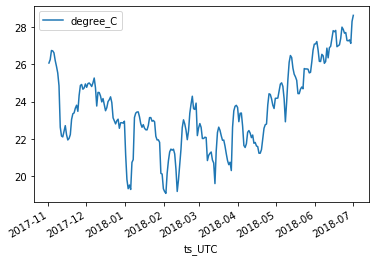

In [38]:
# Plot SST
df_sst_over_mooring.plot(x='ts_UTC',y='degree_C')


In [39]:
# Elsewhere, I analyzed ADEON EN615 deployment at Cape Hatteras to detect 
# whistles, using Silbido. This analysis yielded a csv file with the following features: 
# bottom temperature (at a depth of about 290m) and a measure of the amount of whistling 
# per recording interval
df_whistles = pd.read_csv('whistles_ADEON.csv', header=0)
df_whistles.head()


,time,degrees_C_Bottom,fraction_Whistling
0,2017-11-24T14:18:56Z,NaN,0.00
1,2017-11-24T14:39:56Z,10.27,0.00
2,2017-11-24T15:00:56Z,10.28,0.00
3,2017-11-24T15:21:56Z,10.30,0.00
4,2017-11-24T15:42:56Z,10.33,0.02


In [40]:
# Convert to datetime like
# df['Time stamp'] = pd.to_datetime(df['Time stamp'], format= '%d/%m/%Y')
df_whistles['ts_UTC'] = pd.to_datetime(df_whistles['time'].str.strip(), format='%Y-%m-%dT%H:%M:%SZ')
#df_whistles.head()


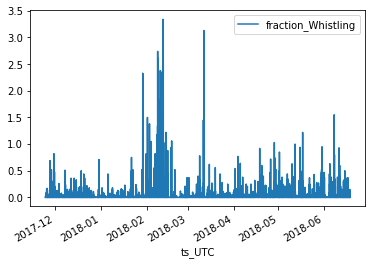

In [41]:
# Plot
df_whistles.plot(x='ts_UTC',y='fraction_Whistling')



Text(0, 0.5, 'SST in degrees C')

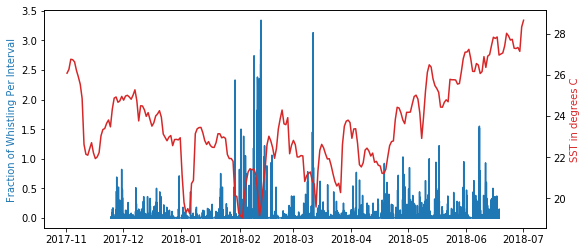

In [42]:
# Is there a relationship between the amount of whistling and the SST? 
# Start by plotting them together
fig, ax1 = plt.subplots(figsize=(9,4))
# Whistles
color1 = 'tab:blue'
ax1.plot(df_whistles['ts_UTC'],df_whistles['fraction_Whistling'], color=color1)
ax1.set_ylabel('Fraction of Whistling Per Interval', color=color1)
# SST
color2 = 'tab:red'
ax2 = ax1.twinx()
ax2.plot(df_sst_over_mooring['ts_UTC'],df_sst_over_mooring['degree_C'], color=color2)
ax2.set_ylabel('SST in degrees C', color=color2)




In [43]:
# There were 4 events (in Winter 2018) where the SST dropped below 20. 
# During 3 of these events, the fraction of whistling was very high.

In [48]:
# Add geometry to the pandas df_sst dataframe and create a geodataframe
df_sst['geometry'] = df_sst.apply(lambda row: Point(row.degrees_east, row.degrees_north), axis=1) 
df_sst = gpd.GeoDataFrame(df_sst, crs={'init' :'epsg:4326'})

In [50]:
# Plot SST field at a specified (datetime) ts_UTC
# Pick a time when there are a lot of vocalizations AND the SST is low.
#help(gpd.GeoDataFrame)
df_sst_snapshot = df_sst.loc[lambda df_sst: df_sst['ts_UTC'] == '2018-02-01 09:00:00']
df_sst_snapshot.head()



,UTC,degrees_north,degrees_east,degree_C,degree_C.1,ts_UTC,geometry
239292,2018-02-01T09:00:00Z,35.0,-75.25,19.282,0.4,2018-02-01 09:00:00,POINT (-75.25000 35.00000)
239293,2018-02-01T09:00:00Z,35.0,-75.24,19.365,0.4,2018-02-01 09:00:00,POINT (-75.24000 35.00000)
239294,2018-02-01T09:00:00Z,35.0,-75.23,19.448,0.4,2018-02-01 09:00:00,POINT (-75.23000 35.00000)
239295,2018-02-01T09:00:00Z,35.0,-75.22,19.530,0.4,2018-02-01 09:00:00,POINT (-75.22000 35.00000)
239296,2018-02-01T09:00:00Z,35.0,-75.21,19.611,0.4,2018-02-01 09:00:00,POINT (-75.21000 35.00000)


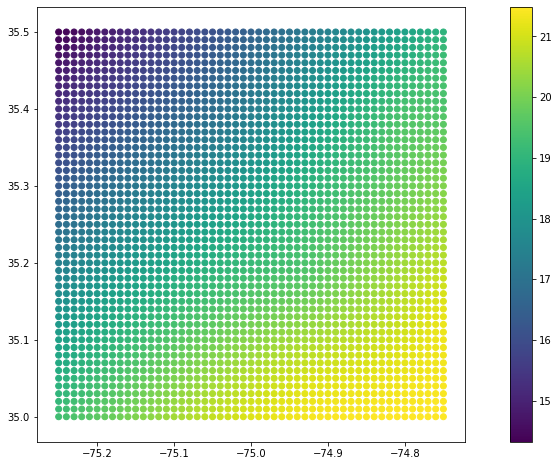

In [51]:
# Plot SST at specified datetime
df_sst_snapshot.plot(column='degree_C', legend=True, figsize=(16,8));

In [52]:
# It looks like the mooring location (35.2N, -75.0E) is at a frontal boundary 
# at this time (when there is a lot of vocalizations)


In [ ]:
# Save SST over mooring to a csv file
#df_sst_over_mooring.to_csv('sst_over_mooring_ADEON1.csv')